In [ ]:
import numpy as np
import tonic
import tonic.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches
from tqdm.notebook import tqdm

#### TODO
Voxel grid?\
Object detection models:
 - Output a fixed number of potential bounding boxes. Say, 4 bounding boxes for whole image.
 - For each bounding box, there is a probability of each class.
Example:
 - 4 bounding boxes per image. 2 classes.\
ex output:\
[
[0, 0, 0, 0, 0.5, 0.5],\
[0, 0, 0, 0, 0.5, 0.5],\
[0, 0, 0, 0, 0.5, 0.5],\
[0, 0, 0, 0, 0.5, 0.5]\
]\
4 x (4+2) tensor
#bb * (#bb + #class)

In [2]:
import sys
sys.path.append("./mnist_sg_cnn")

In [3]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

In [4]:
dir = "/media/user/EVIMO/raw/imo/eval/scene15_dyn_test_01/left_camera/ground_truth_000000"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 16 # T = 100
framerate = 200
epochs=20

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
class EVIMO(Dataset):
    def __init__(self,
                 dir: str,
                 item_to_find: int,
                 num_bins_per_frame: int,
                 #start_idx: int,
                ):
        self.dir = dir
        self.item_to_find = item_to_find
        self.num_bins_per_frame = num_bins_per_frame
        self.length = np.load(self.dir + "/length.npy")
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        
        obj_ids = item["objs_in_mask"][1:]
        if self.item_to_find in obj_ids:
            id = obj_ids.tolist().index(self.item_to_find)
            detection_masks = torch.from_numpy(item["mask"]) == torch.from_numpy(np.asarray(obj_ids[:, None, None]))
            boxes = masks_to_boxes(detection_masks)
            box = boxes[id]
        else:
            box = torch.zeros([4])

        

        #target = np.tile(target, (self.num_bins_per_frame, 1))
        #print(item["events"].dtype)
        events = np.asarray(item["events"])
        #target = target

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToFrame(sensor_size=sensor_size,
                                                          n_event_bins=self.num_bins_per_frame)
                                      ])

        # #transform = transforms.ToFrame(sensor_size=sensor_size, )
        events = frame_transform(events)

        #return {"data": events, "targets": target}
        return events, box

    def __len__(self) -> int:
        return self.length # - self.start_idx
    
    

In [6]:
tonic_dataset = EVIMO(dir="./data/EVIMO/left_cam/scene13_test5", item_to_find=23, num_bins_per_frame=num_bins_per_frame)

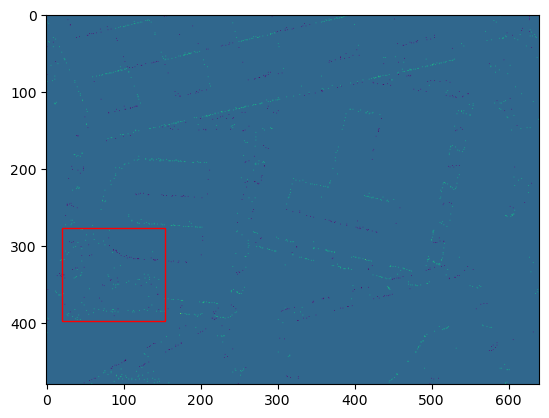

In [7]:
events, box = tonic_dataset[0]
events = events[3]

arr = events[1] - events[0]
ax = plt.gca()
ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none'))
plt.imshow(arr)

In [8]:
trainloader = DataLoader(tonic_dataset, batch_size=batch_size, shuffle=False)

In [9]:
data, target = next(iter(trainloader))

loss = torch.nn.SmoothL1Loss()

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        if r[i].shape != tgt.shape:
            print(f"Loss Readout shape : {r[i].shape}")
            print(f"Loss Target shape : {tgt.shape}")
        loss_tv += loss(r[i],tgt) 
    return loss_tv


convnet_sg = lenet_decolle_model.LenetDECOLLE(out_channels=4,
                    Nhid=[64, 128, 256], #Number of convolution channels
                    Mhid=[256, 512],
                    kernel_size=[8, 16, 32],
                    pool_size=[4, 8, 8],
                    input_shape=[2, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=3,
                    num_mlp_layers=2,
                    lc_ampl=0.5).to(device)

#net = lenet_decolle_model.LenetDECOLLE(Nhid=[1,8],Mhid=[32,64],out_channels=2, input_shape=[2, 480, 640]).to(device)

#convnet_sg

data_d = data.to(device)
target_d = target.to(device)
convnet_sg.init_parameters(data_d) # Modifies readout dim

LAYER SIZE: 1210944
STDV: 0.000454368247933539
LAYER SIZE: 34048
STDV: 0.002709718654762875
LAYER SIZE: 512
STDV: 0.022097086912079608
LAYER SIZE: 256
STDV: 0.03125
LAYER SIZE: 512
STDV: 0.022097086912079608


In [ ]:
from tqdm.notebook import tqdm
from torchvision.ops import box_iou

opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1, betas=[0., .95])
for e in range(epochs):        
    error = []
    accuracy=[]
    for data, label in tqdm(iter(trainloader), desc=f"Epoch {e}"):
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet_sg.init(data_d, burnin=10)
        readout = 0

        #print(label_d)
        #print(label_d.shape)
        #break

        data_d = data_d.transpose(0, 1)
        
        for n in range(num_bins_per_frame):
           # print(f"Data shape: {data_d[n].shape}, overall: {data_d.shape}")
            st, rt, ut = convnet_sg.forward(data_d[n])
            #print("Readout")
            #print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            #print(f"Label: {label_d[n].shape} overall {label_d.shape}")
            #print(label_d[n].shape)
            #print(label_d[n])
            loss_tv = decolle_loss(rt, st, label_d)
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]

        print("READOUT")
        print(readout)

        print("LABEL")
        print(label_d)

        #print("IoU")
        IoU = torch.diagonal(box_iou(label_d, readout))
        #print(IoU)

        correctly_found = torch.round(IoU)  # IoUs > 0.5 are 1's (correct), <= 0.5 are 0's (wrong)
            
        #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
        #print(correctly_found)


        error += (correctly_found == 0).float()
        accuracy += correctly_found.float()
        
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = './evimo_obj_det.pth'
    torch.save(convnet_sg.state_dict(), PATH)

Epoch 0:   0%|          | 0/120 [00:00<?, ?it/s]

READOUT
tensor([[24.2393, 17.7063, 25.5153, 18.8295],
        [23.8445, 19.0171, 25.8204, 18.9188],
        [23.9538, 19.9330, 26.5497, 17.7738],
        [24.7424, 18.9891, 25.3731, 17.7407]], device='cuda:0',
       grad_fn=<AddBackward0>)
LABEL
tensor([[ 20., 277., 154., 397.],
        [ 20., 280., 154., 399.],
        [ 20., 282., 154., 402.],
        [ 20., 285., 155., 405.]], device='cuda:0')
READOUT
tensor([[24.0566, 19.5504, 27.0632, 16.9347],
        [23.9866, 19.5355, 24.1501, 16.3980],
        [24.3804, 19.6261, 26.0119, 17.1314],
        [24.8262, 17.3496, 26.0589, 17.1911]], device='cuda:0',
       grad_fn=<AddBackward0>)
LABEL
tensor([[ 20., 317., 157., 441.],
        [ 20., 320., 157., 444.],
        [ 20., 323., 157., 448.],
        [ 20., 326., 157., 451.]], device='cuda:0')
READOUT
tensor([[24.6472, 18.4501, 24.0094, 18.5646],
        [24.2475, 18.9704, 24.6446, 17.5243],
        [24.9359, 18.3003, 25.3210, 17.5924],
        [25.2039, 19.8395, 26.8879, 16.6679]], devic

In [ ]:
pt = [[1, 1, 3, 3]]
pt = torch.from_numpy(np.asarray(pt))
pt2 = [[1, 1, 3, 4]]
pt2 = torch.from_numpy(np.asarray(pt2))

box_iou(pt, pt2)

In [ ]:
pt = [[1, 1, 3, 3],
     [1, 1, 3, 4]]
pt = torch.from_numpy(np.asarray(pt))

torch.diagonal(box_iou(pt, pt))